In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


In [14]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, transform = None):
        self.df = pd.read_csv('../../data/train.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        assert(x.shape == (reqd_len, channels))
        return x
        
dataset = IMUDataset()

(128100, 8)


In [15]:
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(dataset) // reqd_len)]

trainloader = DataLoader(dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
trainloader2 = DataLoader(dataset, batch_size = 1, sampler = SubsetRandomSampler(train_indices), drop_last = True)

torch.Size([1, 150, 3])


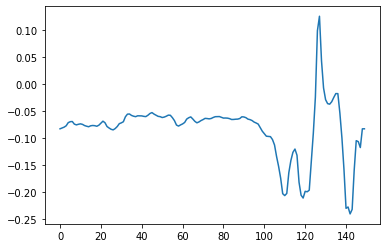

In [16]:
signal = next(iter(trainloader2))
print(signal.shape)
signal = signal.detach().numpy()
signal = np.transpose(signal).reshape(-1)
t = range(150)
plt.plot(t, signal[150 : 300])

In [87]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 2, kernel_size = 3),
            nn.Tanh(),
            nn.Conv1d(in_channels = 2, out_channels = 1, kernel_size = 3),
            nn.Tanh()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 1, out_channels = 2, kernel_size = 3),
            nn.Tanh(),
            nn.ConvTranspose1d(in_channels = 2, out_channels = 3, kernel_size = 3),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(146, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, x, encode = False, classify = False) :
        x = torch.transpose(x, 1, 2)
        features = self.encoder(x)
        
        if encode and not classify:
            return features
        elif not encode and classify :
            features = features.view(-1, 146)
            return self.classifier(features)
        else : 
            return self.decoder(features)

In [88]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

In [89]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [90]:
num_epochs = 50
total_step = len(dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, signals in enumerate(trainloader) :
        if torch.cuda.is_available():
            signals = Variable(signals).cuda().float()
        else : 
            signals = Variable(signals).float()
        
        reconstr = Net.forward(signals)
        signal_ = torch.transpose(signals, 1, 2).float()
        loss = criterion(reconstr, signal_)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../../saved_models/autoencoder4.pt')
        print('Saving model', min_loss)

epoch =  0  step =  0  of total steps  106  loss =  0.040095262229442596
epoch =  0  step =  20  of total steps  106  loss =  0.029977822676301003
epoch =  0  step =  40  of total steps  106  loss =  0.029027650132775307
epoch =  0  step =  60  of total steps  106  loss =  0.030635572969913483
epoch =  0  step =  80  of total steps  106  loss =  0.02773032896220684
epoch =  0  step =  100  of total steps  106  loss =  0.02605361118912697
Saving model 0.03221077417497927
epoch =  1  step =  0  of total steps  106  loss =  0.03136350214481354
epoch =  1  step =  20  of total steps  106  loss =  0.016710761934518814
epoch =  1  step =  40  of total steps  106  loss =  0.03294524922966957
epoch =  1  step =  60  of total steps  106  loss =  0.015702586621046066
epoch =  1  step =  80  of total steps  106  loss =  0.010718297213315964
epoch =  1  step =  100  of total steps  106  loss =  0.011123818345367908
Saving model 0.018508381816505822
epoch =  2  step =  0  of total steps  106  loss 

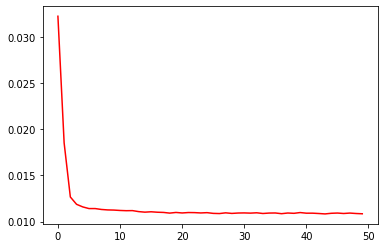

In [91]:
j = range(50)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [92]:
print(Net.encoder[0].weight)
print(Net.encoder[2].weight)
print(Net.decoder[0].weight)
print(Net.decoder[2].weight)

Parameter containing:
tensor([[[ 0.0792, -0.0953, -0.0611],
         [ 0.1170, -0.0391,  0.0559],
         [ 0.0437,  0.4910, -0.3439]],

        [[ 0.0613, -0.3781,  0.3481],
         [-0.0257,  0.0569, -0.1374],
         [-0.2155,  0.3043,  0.3086]]], requires_grad=True)
Parameter containing:
tensor([[[0.0207, 0.1522, 0.5878],
         [0.4211, 0.0926, 0.1234]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.5007,  0.7570, -0.0034],
         [ 0.3780,  0.2416,  0.8232]]], requires_grad=True)
Parameter containing:
tensor([[[-0.2537,  0.0683,  0.1096],
         [ 0.1558,  0.0474,  0.2328],
         [-0.0426,  0.7858,  0.5121]],

        [[ 0.1804, -0.2291, -0.0411],
         [-0.0100, -0.2931,  0.0790],
         [ 0.0574,  0.7705, -0.0578]]], requires_grad=True)


### Checking reconstruction quality visually
Works correctly now!

In [93]:
Net = AutoEncoder()
Net.load_state_dict(torch.load('../../saved_models/autoencoder4.pt'))
Net = Net.eval()

tensor(0.0072, grad_fn=<MeanBackward0>)


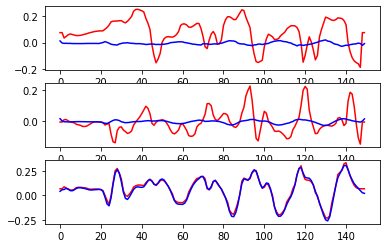

In [94]:
x = next(iter(trainloader2))
y = Net.forward(x.float())
loss = criterion(torch.transpose(x, 1, 2).float(), y)

x = torch.transpose(x, 1, 2)
x = x.detach().numpy()
y = y.detach().numpy()

fig, ax = plt.subplots(3, 1)
ax[0].plot(x[0][0], 'r')
ax[0].plot(y[0][0], 'b')
print(loss)
ax[1].plot(x[0][1], 'r')
ax[1].plot(y[0][1], 'b')
ax[2].plot(x[0][2], 'r')
ax[2].plot(y[0][2], 'b')

### Now training the classifier

In [24]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(120150, 8)
(19950, 8)
(20100, 8)


In [25]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [29]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../saved_models/autoencoder2.pt'), strict = False)
# # freezing encoder and decoder layers
Net.encoder[0].requires_grad = False
Net.encoder[2].requires_grad = False
Net.decoder[0].requires_grad = False
Net.decoder[2].requires_grad = False

In [30]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [31]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net.forward(images, classify = True)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, classify = True)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, epoch' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), 'autoencoder_classifier.pt')

epoch =  0  step =  0  of total steps  100  loss =  1.603764533996582
epoch =  0  step =  20  of total steps  100  loss =  1.6434917449951172
epoch =  0  step =  40  of total steps  100  loss =  1.6929755210876465
epoch =  0  step =  60  of total steps  100  loss =  1.5619838237762451
epoch =  0  step =  80  of total steps  100  loss =  1.4808571338653564
epoch :  0  /  30  | TL :  1.539853526353836  | VL :  1.4440586566925049
saving model
epoch =  1  step =  0  of total steps  100  loss =  1.6428272724151611
epoch =  1  step =  20  of total steps  100  loss =  1.2799149751663208
epoch =  1  step =  40  of total steps  100  loss =  1.3775889873504639
epoch =  1  step =  60  of total steps  100  loss =  1.4892210960388184
epoch =  1  step =  80  of total steps  100  loss =  1.460293173789978
epoch :  1  /  30  | TL :  1.5201008546352386  | VL :  1.4443871974945068
epoch =  2  step =  0  of total steps  100  loss =  1.3750784397125244
epoch =  2  step =  20  of total steps  100  loss =  

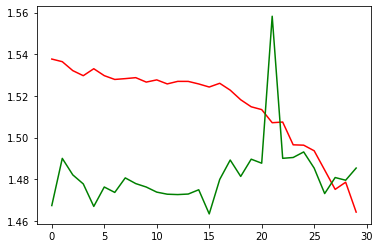

In [98]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [99]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images, classify = True)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [100]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.42875
0.4296875
0.4140625


The symmetrical fully convolutional autoencoder doesn't work well. So, next we try using an asymmetrical autoencoder (asymmetrical since it will only have maxpool in encoder) (TODO)

In [32]:
# TODO - (MEDIUM-PRIORITY)
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # defining layers
        self.conv1 = nn.Conv1d(3, 10, 3)
        self.mp = nn.MaxPool1d(2, 2)
        
        self.dconv1 = nn.ConvTranspose1d(10, 3, 3)
        nn.init.xavier_uniform_(self.conv1.weight, gain = nn.init.calculate_gain('relu'))
        
    def forward(self, signal):
        signal = signal.view(-1, 150 * 3)
        out = F.relu(self.fc1(signal))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out), dim = 1)
        return out

Net = AutoEncoder()
if torch.cuda.is_available():
    print('Model on GPU')
    Net = Net.cuda()